In [1]:
import pandas as pd 
from datetime import datetime 
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import joblib
from datetime import datetime

In [2]:
merged = pd.read_csv(r'../data/long_merge.csv')

In [3]:
zones = [16, 17, 21,23,24, 46,47, 51,52,53,54]
rtu = 4
cols = []

for zone in zones:
    for column in merged.columns:
        if (
            f"zone_0{zone}" in column
            and "co2" not in column
            and "hw_valve" not in column
            and "cooling_sp" not in column
            and "heating_sp" not in column
        ):
            cols.append(column)

for zone in zones:
    for column in merged.columns:
        if f"zone_0{zone}" in column:
            if "cooling_sp" in column or "heating_sp" in column:
                cols.append(column)
# for rtu in rtus:
#     for column in merged.columns:
#         if f"rtu_00{rtu}_fltrd_sa" in column:
#                 cols.append(column)
cols = (
    ["date"]
    + cols
    + [
        f"rtu_00{rtu}_fltrd_sa_flow_tn",
        f"rtu_00{rtu}_sa_temp",
        "air_temp_set_1",
        "air_temp_set_2",
        "dew_point_temperature_set_1d",
        "relative_humidity_set_1",
        "solar_radiation_set_1",
    ]
)
input_dataset = merged[cols]

In [4]:
len(cols)

50

In [5]:
input_dataset['date'] = pd.to_datetime(input_dataset['date'], format = "%Y-%m-%d %H:%M:%S")
df_filtered = input_dataset[ (input_dataset.date.dt.date >date(2019, 3, 1)) & (input_dataset.date.dt.date< date(2021, 1, 1))]

if df_filtered.isna().any().any():
    print("There are NA values in the DataFrame columns.")

C:\Users\arbal\AppData\Local\Temp\ipykernel_153088\1855433847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_dataset['date'] = pd.to_datetime(input_dataset['date'], format = "%Y-%m-%d %H:%M:%S")


In [6]:
testdataset_df = df_filtered[(df_filtered.date.dt.date >date(2020, 3, 1)) & (df_filtered.date.dt.date <date(2020,7, 1))]
traindataset_df = df_filtered[(df_filtered.date.dt.date >date(2019, 3, 1)) & (df_filtered.date.dt.date <date(2020, 3, 1)) | (df_filtered.date.dt.date >date(2020, 7, 1)) & (df_filtered.date.dt.date <date(2020, 12, 1))]

testdataset_df.set_index('date', inplace=True)
traindataset_df.set_index('date', inplace=True)

testdataset = testdataset_df.values
traindataset = traindataset_df.values

columns_with_na = traindataset_df.columns[traindataset_df.isna().any()].tolist()
columns_with_na

[]

In [7]:
traindataset_df.columns[0:22]

Index(['zone_016_temp', 'zone_016_fan_spd', 'zone_017_temp',
       'zone_017_fan_spd', 'zone_021_temp', 'zone_021_fan_spd',
       'zone_023_temp', 'zone_023_fan_spd', 'zone_024_temp',
       'zone_024_fan_spd', 'zone_046_temp', 'zone_046_fan_spd',
       'zone_047_temp', 'zone_047_fan_spd', 'zone_051_temp',
       'zone_051_fan_spd', 'zone_052_temp', 'zone_052_fan_spd',
       'zone_053_temp', 'zone_053_fan_spd', 'zone_054_temp',
       'zone_054_fan_spd'],
      dtype='object')

In [8]:
len(traindataset), len(testdataset)

(1073512, 391818)

In [9]:
traindataset = traindataset.astype('float32')
testdataset = testdataset.astype('float32')

scaler = StandardScaler()
traindataset = scaler.fit_transform(traindataset)
testdataset = scaler.transform(testdataset)

joblib.dump(scaler, 'scaler_vav_4.pkl')

['scaler_vav_4.pkl']

In [10]:
train,test = traindataset,testdataset

def create_dataset(dataset,time_step):
    x = []
    Y = []
    for i in range(len(dataset) - time_step - 1):
        x.append(dataset[i:(i+time_step),:])
        Y.append(dataset[i+time_step,0:22])
    x= np.array(x)
    Y = np.array(Y)
    return x,Y
time_step = 30
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)



In [11]:
X_train.shape, y_train.shape

((1073481, 30, 49), (1073481, 22))

In [12]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')

checkpoint_path = "lstm_vav_04.keras"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=128, verbose=1, callbacks=[checkpoint_callback])

d:\anaconda3\envs\smartbuilding\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8387/8387 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0649
Epoch 1: val_loss improved from inf to 0.36970, saving model to lstm_vav_04.keras
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 511s 60ms/step - loss: 0.0648 - val_loss: 0.3697


In [13]:
model.load_weights(checkpoint_path)

In [14]:
test_predict1 = model.predict(X_test)

12244/12244 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step


In [15]:
idx_2_col = {}
for i, col in enumerate(traindataset_df.columns[1:]):
    idx_2_col[i] = col

idx_2_col

{0: 'zone_016_fan_spd',
 1: 'zone_017_temp',
 2: 'zone_017_fan_spd',
 3: 'zone_021_temp',
 4: 'zone_021_fan_spd',
 5: 'zone_023_temp',
 6: 'zone_023_fan_spd',
 7: 'zone_024_temp',
 8: 'zone_024_fan_spd',
 9: 'zone_046_temp',
 10: 'zone_046_fan_spd',
 11: 'zone_047_temp',
 12: 'zone_047_fan_spd',
 13: 'zone_051_temp',
 14: 'zone_051_fan_spd',
 15: 'zone_052_temp',
 16: 'zone_052_fan_spd',
 17: 'zone_053_temp',
 18: 'zone_053_fan_spd',
 19: 'zone_054_temp',
 20: 'zone_054_fan_spd',
 21: 'zone_016_cooling_sp',
 22: 'zone_016_heating_sp',
 23: 'zone_017_cooling_sp',
 24: 'zone_017_heating_sp',
 25: 'zone_021_cooling_sp',
 26: 'zone_021_heating_sp',
 27: 'zone_023_cooling_sp',
 28: 'zone_023_heating_sp',
 29: 'zone_024_cooling_sp',
 30: 'zone_024_heating_sp',
 31: 'zone_046_cooling_sp',
 32: 'zone_046_heating_sp',
 33: 'zone_047_cooling_sp',
 34: 'zone_047_heating_sp',
 35: 'zone_051_cooling_sp',
 36: 'zone_051_heating_sp',
 37: 'zone_053_cooling_sp',
 38: 'zone_053_heating_sp',
 39: 'zone_

In [16]:
test_predict1.shape

(391787, 22)

In [17]:
test_predict1_unscaled = test_predict1*scaler.scale_[0:22] + scaler.mean_[0:22]
y_test_unscaled = y_test*scaler.scale_[0:22] + scaler.mean_[0:22]

d:\anaconda3\envs\smartbuilding\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
d:\anaconda3\envs\smartbuilding\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


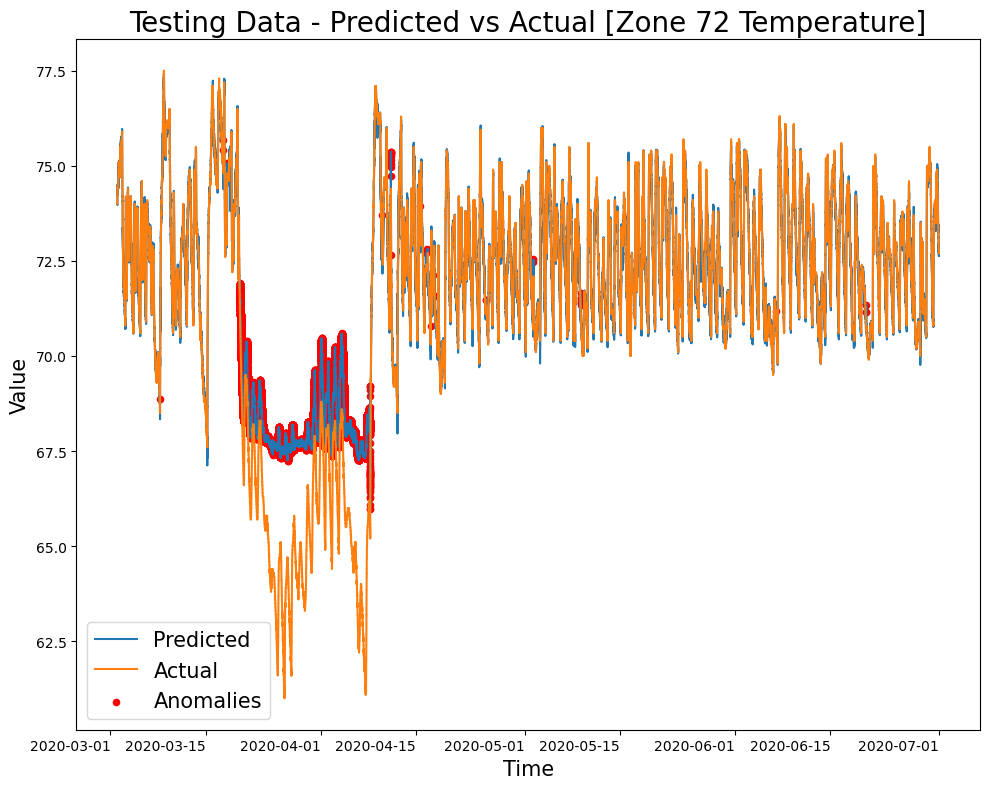

In [18]:
%matplotlib inline
var = 0

df = pd.DataFrame([testdataset_df.index[31:],test_predict1_unscaled[:,var], y_test_unscaled[:,var]] ).T
fig, ax = plt.subplots(figsize=(10,8))
df.plot(x = 0, y=1, ax = ax, label = 'Predicted')
df.plot(x = 0, y=2, ax = ax, label = 'Actual')

anomalies = df.where(df[1]-df[2]>0.38)[0]
df['anomalies'] = anomalies

df_new = df.dropna()

df_new.plot.scatter(x='anomalies', y=1,  c='r', ax = ax, label = 'Anomalies')

# ax.scatter(anomalies,test_predict1[anomalies,var], color='black',marker ="o",s=100 )


ax.set_title('Testing Data - Predicted vs Actual [Zone 72 Temperature]', fontsize=20)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Value', fontsize = 15)
ax.legend(fontsize = 15)
fig.tight_layout()

d:\anaconda3\envs\smartbuilding\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Text(0, 0.5, 'MSE')

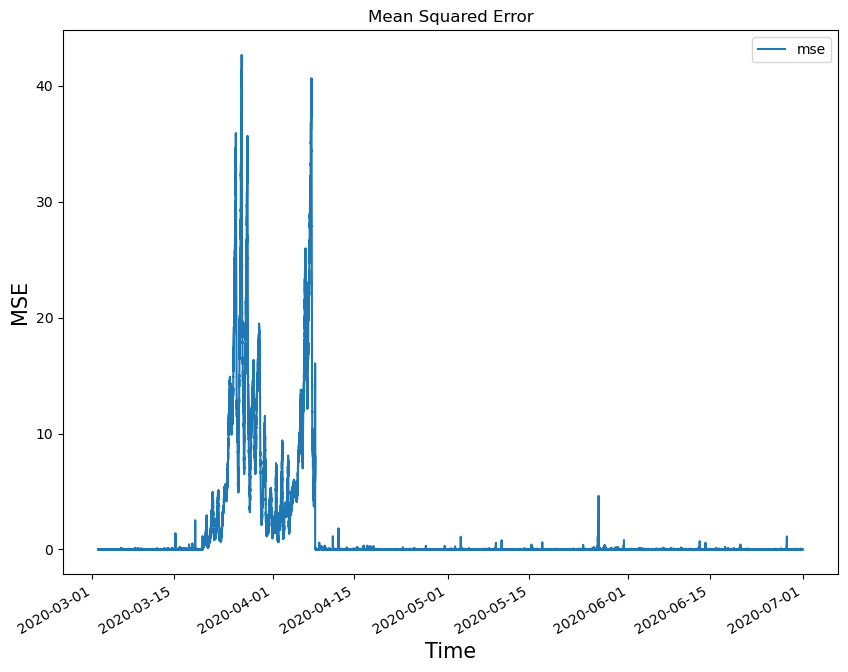

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
df['residual'] = df[1] - df[2]
df['mse'] = (df[1] - df[2])**2
df.plot(x = 0, y='mse', figsize=(10,8), title = 'Mean Squared Error', ax = ax)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('MSE', fontsize = 15)


['pca_vav_4.pkl']

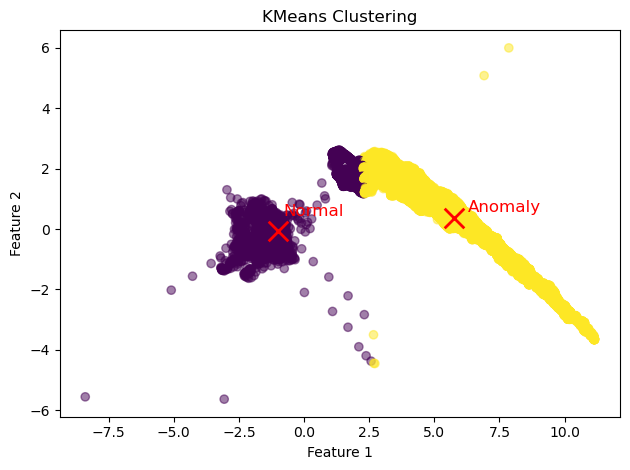

In [20]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generating random data for demonstration
np.random.seed(0)
X = (test_predict1 - y_test)

k = 2

pca = PCA(n_components=2)
X = pca.fit_transform(X)

kmeans = KMeans(n_clusters=k)

kmeans.fit(X)



# Getting the cluster centers and labels
centroids = kmeans.cluster_centers_
# centroids = pca.transform(centroids)
labels = kmeans.labels_

# Plotting the data points and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, linewidths=2)
plt.text(centroids[0,0]+0.2, centroids[0,1]+0.5, 'Normal', fontsize=12, color='red')
plt.text(centroids[1,0]+0.5, centroids[1,1]+0.2, 'Anomaly', fontsize=12, color='red')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()

joblib.dump(kmeans, 'kmeans_vav_4.pkl')
joblib.dump(pca, 'pca_vav_4.pkl')

In [21]:
(test_predict1 - y_test).shape

(391787, 22)

In [22]:
k = 60
X= test_predict1 - y_test
processed_data = []
feat_df = pd.DataFrame(columns=["mean","std",])
for i in range(0,len(X), 60):
    mean = X[i:i+k].mean(axis = 0)
    std = X[i:i+k].std(axis = 0)
    max = X[i:i+k].max(axis = 0)
    min = X[i:i+k].min(axis = 0)
    iqr = np.percentile(X[i:i+k], 75, axis=0) - np.percentile(X[i:i+k], 25,axis=0)
    data = np.concatenate([mean, std, max, min, iqr])
    processed_data.append([data])
processed_data = np.concatenate(processed_data,axis=0) 

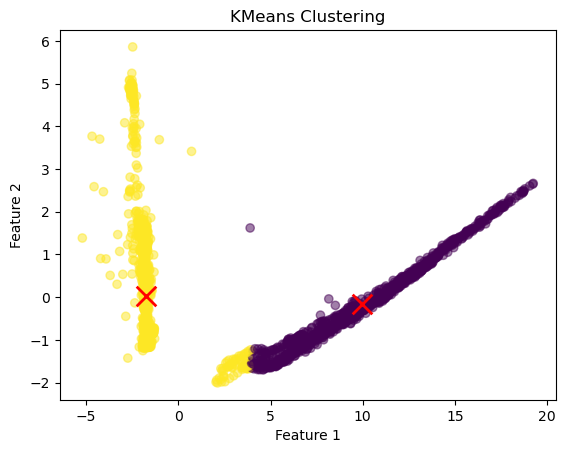

In [23]:
X = processed_data

kmeans = KMeans(n_clusters=2, algorithm='elkan', max_iter=1000, n_init = 5)

kmeans.fit(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)


# Getting the cluster centers and labels
centroids = kmeans.cluster_centers_
centroids = pca.transform(centroids)
labels = kmeans.labels_

# Plotting the data points and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, linewidths=2)
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


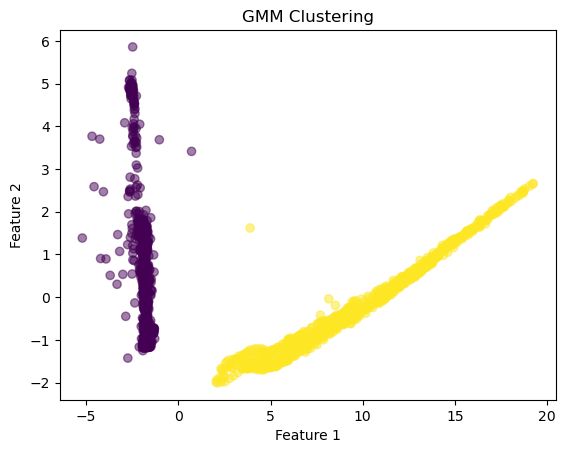

In [24]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generating random data for demonstration
np.random.seed(0)
X = processed_data

# Creating the GMM instance with desired number of clusters
gmm = GaussianMixture(n_components=2, init_params='k-means++')

# Fitting the model to the data
gmm.fit(X)
labels = gmm.predict(X)


pca = PCA(n_components=2)
X = pca.fit_transform(X)


# Getting the cluster labels

# Plotting the data points with colors representing different clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



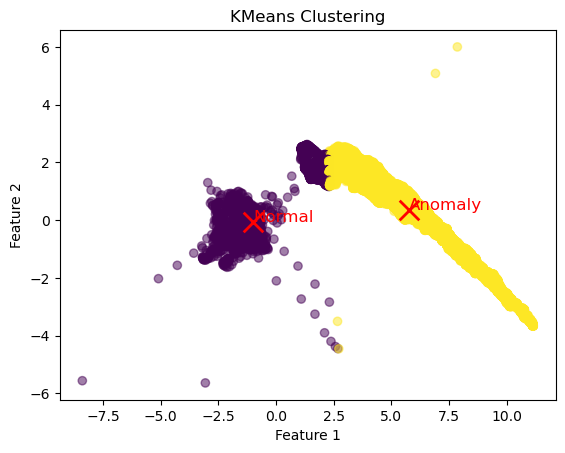

In [25]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
# Generating random data for demonstration
np.random.seed(0)
X = test_predict1 - y_test 

kmeans = KMeans(n_clusters=2)

kmeans.fit(X)


pca = PCA(n_components=2)
X = pca.fit_transform(X)



# Getting the cluster centers and labels
centroids = kmeans.cluster_centers_
centroids = pca.transform(centroids)
labels = kmeans.labels_

# Plotting the data points and cluster centers
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, linewidths=2)
plt.text(centroids[0,0], centroids[0,1], 'Normal', fontsize=12, color='red')
plt.text(centroids[1,0], centroids[1,1], 'Anomaly', fontsize=12, color='red')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
